In [ ]:
# Задание 1
def findMaxsubArray(nums):
  ans = nums[0]
  index_left, index_right = 0, 0
  summ, min_summ = 0, 0
  min_pos = -1
  current = 0
  for i in range (1,len(nums)):
    summ += nums[i]
    current = summ - min_summ
    if current > ans:
      ans = current
      index_left = min_pos + 1
      index_right = i
    if summ < min_summ:
      min_summ = summ
      min_pos = i
  return nums[index_left:index_right+1]

In [ ]:
A = [-2,1,-3,4,-1,2,1,-5,4]
findMaxsubArray(A)

[4, -1, 2, 1]

In [ ]:
# Задание 2

In [3]:
import numpy as np 
import pandas as pd
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

In [4]:
# имопортируем гугл диск - там находится датасет
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
# посмотрим структуру папок
P='/content/drive/My Drive/Intership/'
M='/content/drive/My Drive/Intership/male'
F='/content/drive/My Drive/Intership/female'
for dirs,folder,files in os.walk(M):
  print (len(files))
for dirs,folder,files in os.walk(P):
  print (len(files)) 
  print (dirs)

50001
0
/content/drive/My Drive/Intership/
50001
/content/drive/My Drive/Intership/female
50001
/content/drive/My Drive/Intership/male


In [102]:
# выберем все файлы формата jpg и создадим датафрейм из имен файлов с указанием пола
import glob
Files= glob.glob('/content/drive/My Drive/Intership/*/*.jpg')
correct_filenames, genders= [], []
for filename in Files:
    _,_,_,_,_, gender, name = filename.split('/')
    correct_filenames.append(name)
    genders.append(gender)

data = {"img_name": correct_filenames, 
        "gender": genders}
df = pd.DataFrame(data)

In [103]:
# используем LabelEncoder для кодирования пола
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['gender'])
df.head(5) 

,img_name,gender,encoded_labels
0,081688.jpg,female,0
1,081699.jpg,female,0
2,081689.jpg,female,0
3,081692.jpg,female,0
4,081691.jpg,female,0


In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100002 entries, 0 to 100001
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   img_name        100002 non-null  object
 1   gender          100002 non-null  object
 2   encoded_labels  100002 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


In [24]:
# выберем устройство
torch.cuda.current_device()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [29]:
# трансформируем изображения, используя Compose и приведем к формату torch.FloatTensor
transform = transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [30]:
transform

Compose(
    RandomRotation(degrees=(-5, 5), resample=False, expand=False)
    RandomHorizontalFlip(p=0.5)
    RandomResizedCrop(size=(224, 224), scale=(0.96, 1.0), ratio=(0.95, 1.05), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [31]:
# подготовим Dataset для дальнейшей работы с применением трансформации
from torch.utils.data import Dataset
import torch

class TESNamesDataset(Dataset):
     def __init__(self, df, data_root,transform=None):
        self.data_root = data_root
        self.transform = transform
        self.df = df
      
     def __len__(self):
        return len(self.df)
    
     def __getitem__(self, index):
       i_name = os.path.join(self.data_root, self.df.loc[index, 'gender'], self.df.loc[index, 'img_name'])
       image = Image.open(i_name)
       image = image.resize((300,300))
       label = torch.tensor(self.df.loc[index, 'encoded_labels'])
       if self.transform is not None:
         image = self.transform(image)
       return image,  label



data_root = '/content/drive/My Drive/Intership/'
dataset = TESNamesDataset(df, data_root, transform)
print(len(dataset))

100002


In [32]:
# разделим датасет на тренировочную и тестовую выборки
batch_size = 128
validation_split = .3
shuffle_dataset = True


dataset_size = len(df)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(42)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [33]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [34]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=4)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Male


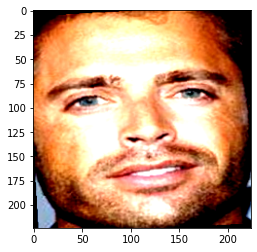

In [35]:
# посмотрим на случайные изображения из сформированного train_loader 
dataiter = iter(train_loader)
images, labels = dataiter.next()
gender_mapping = {0: 'Female', 1: 'Male'}
image, label = images[0], labels[0]
image = image / 2 + 0.5     npimg = image.numpy()
npimg = np.transpose(npimg, (1, 2, 0))
plt.imshow(npimg)
print (gender_mapping[label.item()]) 

In [39]:
#  для классификации  загрузим  и используем модель resnet50
model_conv = torchvision.models.resnet50(pretrained=True)

In [40]:
model_conv = model_conv.to(device)  # On GPU
print(model_conv)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [46]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model_conv.parameters(), lr=0.0001)

In [47]:
# функция для определения метрики accuracy
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [48]:
# определим путь, где будем хранить лучшие показатели  модели
from pathlib import Path
path = Path("/content/drive/My Drive/model_gender_3")
path.mkdir(exist_ok=True, parents=True) # папка создается на вашем гугл диске. вместе с "родителями"
assert path.exists()
checkpoint_filename = "current_checkpoint.pt"  
checkpoint_path =str(path / checkpoint_filename)

In [49]:
# тренируем модель
import torch.nn.functional as F

n_epochs = 2
print_every = 50
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to(device), target_.to(device)# on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs =  model_conv(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model_conv.eval()
        for data_t, target_t in (validation_loader):
            data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
            outputs_t = model_conv(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(validation_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        #  сохраним лучшие веса PyTorch модели
        if network_learned:
          valid_loss_min = batch_loss
          torch.save(model_conv.state_dict(), checkpoint_path)
          print('Detected network improvement, saving current model')
    model_conv.train()
     

Epoch 1

Epoch [1/2], Step [0/547], Loss: 0.6829
Epoch [1/2], Step [20/547], Loss: 0.6453
Epoch [1/2], Step [40/547], Loss: 0.5605
Epoch [1/2], Step [60/547], Loss: 0.5498
Epoch [1/2], Step [80/547], Loss: 0.5101
Epoch [1/2], Step [100/547], Loss: 0.4867
Epoch [1/2], Step [120/547], Loss: 0.4791
Epoch [1/2], Step [140/547], Loss: 0.4391
Epoch [1/2], Step [160/547], Loss: 0.4445
Epoch [1/2], Step [180/547], Loss: 0.4387
Epoch [1/2], Step [200/547], Loss: 0.4034
Epoch [1/2], Step [220/547], Loss: 0.3645
Epoch [1/2], Step [240/547], Loss: 0.4042
Epoch [1/2], Step [260/547], Loss: 0.3881
Epoch [1/2], Step [280/547], Loss: 0.3630
Epoch [1/2], Step [300/547], Loss: 0.4035
Epoch [1/2], Step [320/547], Loss: 0.3869
Epoch [1/2], Step [340/547], Loss: 0.3554
Epoch [1/2], Step [360/547], Loss: 0.3472
Epoch [1/2], Step [380/547], Loss: 0.3680
Epoch [1/2], Step [400/547], Loss: 0.3237
Epoch [1/2], Step [420/547], Loss: 0.3279
Epoch [1/2], Step [440/547], Loss: 0.4079
Epoch [1/2], Step [460/547], Lo

In [50]:
# импортируем  обученную модель с лучшим лоссом
model_conv.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

In [91]:
# тестовый датасет из 14 случайных изображений (7 мужчин и 7 женщин)
Files_test= glob.glob('/content/drive/My Drive/TEST/*/*.jpg')
correct_filenames, genders= [], []
for filename in Files_test:
    _,_,_,_,_, gender, name = filename.split('/')
    correct_filenames.append(name)
    genders.append(gender)

data_test = {"img_name": correct_filenames, 
        "gender": genders}
df_test = pd.DataFrame(data_test)
lb = LabelEncoder()
df_test['encoded_labels'] = lb.fit_transform(df_test['gender'])

In [92]:
transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [93]:
data_root = '/content/drive/My Drive/TEST/'
dataset_test = TESNamesDataset(df_test, data_root, transform_test)
print(len(dataset_test))

14


In [94]:
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size,
                                               num_workers=4)

In [95]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
pred, gender = [], []
gender_mapping = {0: 'Female', 1: 'Male'}
for i in range (len(dataset_test)):
  image, label = images[i], labels[i]
  with torch.no_grad():
    model_conv.eval()
    image = image / 2 + 0.5  
    npimg = image.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    image_tensor = image.unsqueeze_(0)
    image_tensor = image_tensor.to(device)
    output_ = model_conv(image_tensor)
    output_ = output_.argmax()
    k = output_.item()==label.item()
    pred.append(k)
    gender.append(gender_mapping[label.item()])

In [101]:
import json
Dict = list(zip(correct_filenames, gender, pred))


# функция для создания json файла
def writeToJSONFile(path, fileName, data):
    filePathNameWExt =  path + fileName + '.json'
    with open(filePathNameWExt, 'w') as fp:
        json.dump(data, fp)

writeToJSONFile('/content/drive/My Drive/TEST/', 'results', Dict) 